# Deep Dive into Synthesis Sales

##### Published: 2019-01-02



## Summary

As of Jan 2015 we have been keeping product level data in SF.  This analysis uses this data, along with seat data from CDB.

For this analysis, we should be aware that:

* We only use data from 2015-01-01 onwards
* We exclude all de-bookings (including Qualcomm).
* Line item discounts and traded-in products are treated as opportunity level discounts and applied pro rata to all products in the opportunity.


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xlrd
import dtutil.sfdc as sfdc
from dtutil.accounts import Accounts
sys.path.append('/Users/dane/src/datatools/reports')
from pnhelper import get_product_df
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
year = '2018'

In [2]:
wod = sfdc.WonOppDict.read_from_file()

# remove opportunities < $0
for k, v in dict(wod).items():
    if v.amt_usd < 0:
        del wod[k]

products = ['FIL_050', 'FIL_200', 'FIL_300', 'FIL_250', 'FIL_350', 'ANS_200', 'ANS_300', 'ANS_500']

sales_dict = wod.date_filter('2015-01-01'.format(year), '{}-12-31'.format(year)).sales_by_product()
sales = pd.Series(sales_dict)

## Bookings

Let's start by looking at the cumulative bookings by product which gives us a good indication of which part numbers matter most as well as the relative distribution of customer spending.

Because of our 3-year renewal cycle, it makes sense to look at things over a 3-year period. Looking at yearly bookings  tends to say more about the large deal renewal cycle than the actual product sales.  Looking at the cumulative bookings for the trailing 3-years gives a better indication or product performance although it is still impacted by currency fluctuations. For product data, we only have 3-years of data, so we do not have sufficient data to make historical comparisons yet.

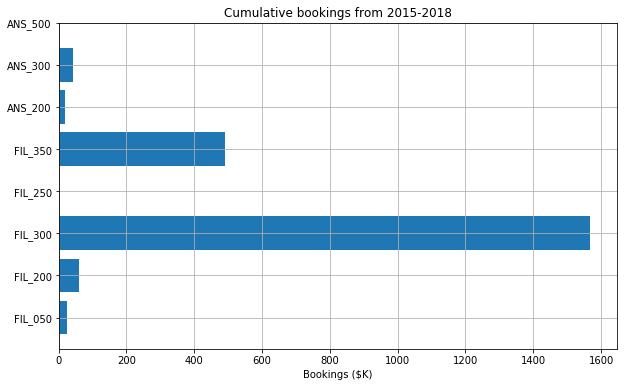

In [4]:
fig = plt.gcf()
fig.set_size_inches(12,1)  
data = sales.reindex(products) / 1000
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Bookings ($K)')
title('Cumulative bookings from 2015-{}'.format(year))
grid(True)
show()

**OPEN QUESTION:** Looking at this data I have to wonder why we have FIL_050 and FIL_250 and even FIL_200 on the price list.  They just take up space.  We have these products to have a lower priced option but, clearly our customers are not that price sensitive as we can see from the quick uptick of the even higher priced FIL_350.

While we don't want to read too much into it, it is still worth looking at the yearly bookings.

##### Total Bookings by Year ($K)

In [5]:
#print('Total Bookings by Year ($K)')
df = get_product_df(wod, products)
df.head()
df.groupby('close_year').amt_usd.sum() / 1000

close_year
2015    423.662390
2016    550.433553
2017    603.438171
2018    624.621022
Name: amt_usd, dtype: float64



## Geographic Breakdown

We can look at the cumulative bookings by territory to get a feel for the geographic distribution.

In [6]:
df = get_product_df(wod, products)
#df.head(1)
all_products = pd.DataFrame(wod.sales_as_dlist())
#all_products.head(1)

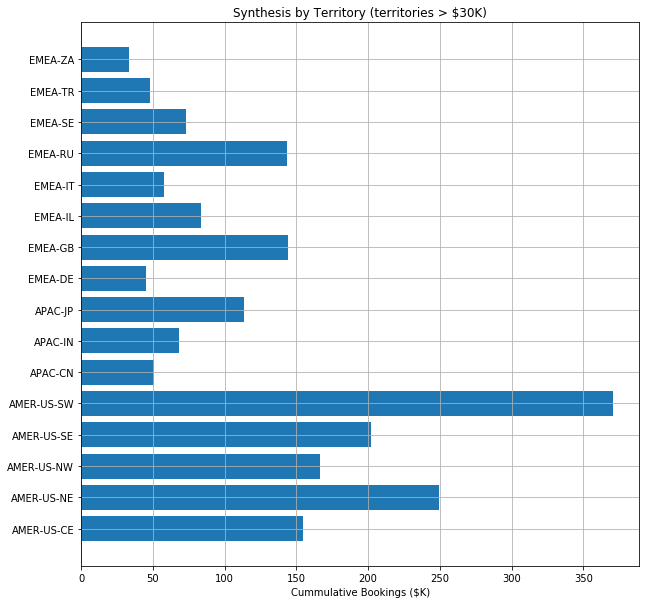

In [7]:
data = df.groupby('territory').amt_usd.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(10,10)
over50 = data[data > 30]
pos = np.arange(len(over50))
barh(pos, over50, align='center')
yticks(pos, over50.index)
xlabel('Cummulative Bookings ($K)')
title('Synthesis by Territory (territories > $30K)')
grid(True)
show()

This gives a good feel of the relative size of each territory. It is useful to see the historical performance of each territory, remembering that the yearly renewal cycle affects these numbers.

##### Bookings by Territory ($K, territories over 10K)

In [9]:
#print('Bookings by Territory ($K)')
x = df.groupby(['territory', 'close_year']).amt_usd.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017] + x[2018]
np.round(x[(x.index != 'Commission Exempt') & (x.total > 10)], 1)

close_year,2015,2016,2017,2018,total
territory,,,,,
AMER-US-CE,28.6,27.8,31.0,67.3,154.7
AMER-US-NE,30.1,82.4,81.8,55.3,249.6
AMER-US-NW,29.0,28.8,63.2,45.3,166.3
AMER-US-SE,36.7,66.9,50.1,48.5,202.2
AMER-US-SW,84.3,90.2,83.6,112.2,370.4
APAC-AU,3.1,6.2,2.7,2.4,14.4
APAC-CN,4.0,7.0,7.3,32.6,50.9
APAC-IN,10.7,56.0,0.1,1.8,68.6
APAC-JP,8.3,9.0,45.5,50.4,113.3


## Ratio of Synthesis Sales to Total Sales

Here we look at, for each territory, what percentage synthesis is of their total sales.  Basically what part of their customer budgets goes to synthesis.

##### Cumulative Bookings and Synthesis Ratio for Territories with over 30K in Sales

In [11]:
#print('Cummulative Bookings and VSS Ratio for Territories with over 30K in Sales')
vss = df.groupby('territory').amt_usd.sum()
all = all_products.groupby('territory').amt_usd.sum()
r = pd.DataFrame(vss) / 1000
r['pct_of_terr'] = 100 * (vss / all)
np.round(r[r.amt_usd > 30], 1)

,amt_usd,pct_of_terr
territory,,
AMER-US-CE,154.7,1.7
AMER-US-NE,249.6,1.8
AMER-US-NW,166.3,1.7
AMER-US-SE,202.2,1.5
AMER-US-SW,370.4,2.7
APAC-CN,50.9,0.8
APAC-IN,68.6,2.9
APAC-JP,113.3,1.5
EMEA-DE,45.2,0.8


## Product Type

Our healthiest product lines have a good balance between recurring and non-recurring revenue.  Here we see that synthesis products have a strong recurring revenue base at 73% of total bookings.

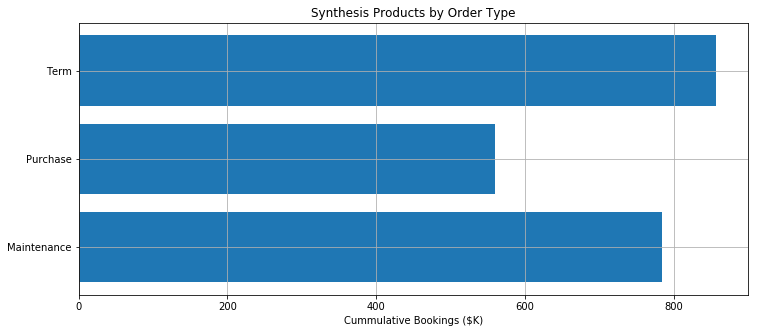

In [12]:
data = df.groupby('order_type').amt_usd.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(12,5)
pos = np.arange(len(data))
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Cummulative Bookings ($K)')
title('Synthesis Products by Order Type')
grid(True)
show()

#data

We can also compute an estimate of the current yearly recurring revenue by taking 1/3rd of 2016, 2017 and 2018 3-year deals, 1/2 of the 2017 and 2018 2-year deals and all the of 2018 1-year deals. 

In [15]:
tb = df[(df.order_type != 'Purchase') & df.close_year.isin([2016, 2017, 2018])]
yearly_rr = 0.333 * tb[(tb.years==3)].amt_usd.sum() +\
            0.500 * tb[(tb.years==2) & ((tb.close_year.isin([2017, 2018])))].amt_usd.sum() +\
            1.000 * tb[(tb.years==1) & (tb.close_year == 2018)].amt_usd.sum()
avg_perp = df[df.order_type == 'Purchase'].amt_usd.sum() / 3.0
print('Yearly Time Based Revenue Run Rate = ${:,}'.format(int(yearly_rr)))
print('Average Yearly Perpetual Revenue = ${:,}'.format(int(avg_perp)))
print('Estimated Yearly Run Rate = ${:,}'.format(int(yearly_rr) + int(avg_perp)))

Yearly Time Based Revenue Run Rate = $458,941
Average Yearly Perpetual Revenue = $186,552
Estimated Yearly Run Rate = $645,493


## Bookings by License Type

Over the last few years, we have seen WAN licenses increase in our largest customers.

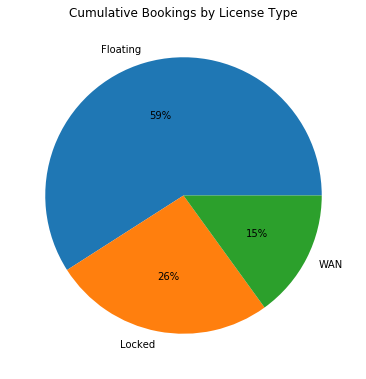

In [16]:
bt = df.groupby('license_type')
x=bt.agg(sum).amt_usd
plt.figure(1, figsize=(6,6))
plt.axes([0.1, 0.1, 0.8, 0.8])
plt.pie(x, labels=x.index, autopct='%1.0f%%')
plt.title('Cumulative Bookings by License Type'.format(year))
plt.show()

Here we see that the percentage of locked licenses is higher than in the Microwave Office and VSS product lines.  I expect this is true because many larger floating customers only have a few synthesis seats so the small accounts, which are often locked, play a larger role.

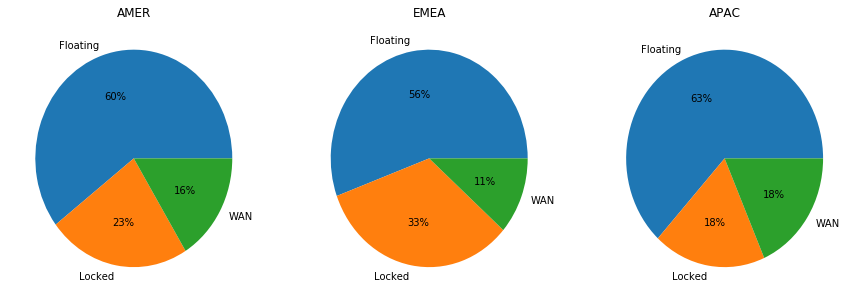

In [17]:
df['continent'] = df.territory.apply(lambda x: x[:4])
# collapse WAN into 1 category
mask = df.license_type.isin(['WAN 1 Timezone', 'WAN 3 Timezones', 'WAN 4 Timezones', 'WAN Worldwide'])
df.loc[mask, 'license_type'] = 'WAN'
btc = df.groupby(['continent','license_type']).agg(sum).amt_usd
plt.figure(1, figsize=(15,5))
sp=1
for continent in ['AMER', 'EMEA','APAC']:
    plt.subplot(1,3,sp) # numrows, numcols, fignum
    sp += 1
    plt.pie(btc[continent], labels=btc[continent].index, autopct='%1.0f%%')
    plt.title('{}'.format(continent))
plt.show()

## Largest Customers

We can rank the customers by their total 3-year spend on synthesis products.

##### Largest synthesis product customers, cumulative bookings in ($K)

In [18]:
a = Accounts()
s = df.groupby('custid').amt_usd.sum() / 1000
x = pd.DataFrame(s)
x['name'] = x.index.map(lambda x: a.get_name(int(x)))
np.round(x.sort_values(by='amt_usd', ascending=False)[:20][['name', 'amt_usd']], 1)
#x.head()

,name,amt_usd
custid,,
9305,Ericsson AB - Kista,107.8
51,Cobham Defense Electronics - Sensor & Antenna ...,77.1
6586,Research Centre Immarat (RCI),56.0
11601,The KEYW Corporation,44.5
3342,Elisra Group - Elisra Electronic Systems,41.9
3186,Honeywell Federal Manufacturing and Technologi...,40.5
3808,"Qualcomm Technologies, Inc. - Headquarters",40.0
2871,Leonardo MW Ltd. - Edinburgh,36.8
3597,"Mercury Systems, Inc. - Corporate Headquarters",35.5


# Non-Renewal Business

As we know, bookings includes both renewal business and non-renewal business.  We define New Business as the non-renewal business plus the growth in renewals but often the growth in renewals, while important, is very hard to determine. It is fairly staightforward to look at the non-renewal business.  All non-renewal business should be new business (except in the case of early respins which are often mis-classified).  The benefit of looking at non-renewal business is that it is a component of new business that is not affected by renewal cycles so it can be compared year-to-year to see if it is improving.

##### Non-renewal by year

In [19]:
for k, v in wod.copy().items():
    if v.renewal or (k == '0063900000qJDk3AAG'):  # delete qualcomm as it is a renewal
        del wod[k]
nr_df = get_product_df(wod, products) 
np.round(nr_df.groupby('close_year').amt_usd.sum() / 1000,0)

close_year
2015    200.0
2016    200.0
2017    301.0
2018    258.0
Name: amt_usd, dtype: float64

##### Non-renewal by territory, total over 10K

In [21]:
x = nr_df.groupby(['territory', 'close_year']).amt_usd.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017] + x[2018]
np.round(x[(x.index != 'Commission Exempt') & (x.total > 10)], 1)

close_year,2015,2016,2017,2018,total
territory,,,,,
AMER-US-CE,23.6,0.0,21.4,34.4,79.4
AMER-US-NE,22.2,16.4,52.7,10.8,102.0
AMER-US-NW,26.4,3.5,26.8,18.7,75.4
AMER-US-SE,19.0,39.8,27.3,12.7,98.7
AMER-US-SW,31.3,16.8,29.0,61.5,138.7
APAC-IN,10.7,56.0,0.0,0.0,66.6
APAC-JP,0.0,0.0,36.3,27.5,63.8
EMEA-BE,0.0,14.6,0.0,0.0,14.6
EMEA-DK,5.7,0.0,0.0,16.2,21.9


## Seats by Product

So far we have only looked at the bookings per product but it is also useful to look at the seats of products.  Of special interest is looking at how many seats of a product are off maintenance as this often indicates customers that have stopped using the product.

##### Number of licensed seats

In [22]:
from dtutil.sqltools import query_to_dataframe, get_cursor_from_url, list_to_query_list
cursor = get_cursor_from_url()

In [23]:
query = """
select * from cdb_custdb
    where partno in {}
        and date = '{}-01-01' and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('NI Academic', 'University')
""".format(list_to_query_list(products), int(year)+1)
seats = query_to_dataframe(cursor, query)

In [25]:
#print('Number of licensed seats')
seats['maintenance'] = 'off'
seats.loc[seats.version=='14.0', 'maintenance'] = 'on'
nls = seats.groupby(['partno', 'maintenance']).qty.sum().unstack().fillna(0)
# seats.head()
nls['pct_on_maint'] = np.round(100 * nls['on'] / (nls['off'] + nls['on']), 1)
nls

maintenance,off,on,pct_on_maint
partno,,,
ANS_300,0.0,2.0,100.0
FIL_050,1.0,5.0,83.3
FIL_200,6.0,8.0,57.1
FIL_300,47.0,103.0,68.7
FIL_350,0.0,25.0,100.0


The maintenance rate for FIL_300 is right on par with Microwave Office.  It is interesting to see that the maintenance rate for FIL_050 is higher than FIL_300 but it's hard to make much of this given the low seat count.

To provide some context, here is the same analysis one our oldest Microwave Office Products.

In [28]:
mquery = """
select * from cdb_custdb
    where partno in ('MWO_226', 'MWO_228')
        and date = '2019-01-01' and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('NI Academic', 'University')
"""
mseats = query_to_dataframe(cursor, mquery)
mseats['maintenance'] = 'off'
mseats.loc[mseats.version=='14.0', 'maintenance'] = 'on'
mnls = mseats.groupby(['partno', 'maintenance']).qty.sum().unstack()
mnls['pct_on_maint'] = np.round(100 * mnls['on'] / (mnls['off'] + mnls['on']), 1)
mnls

maintenance,off,on,pct_on_maint
partno,,,
MWO_226,194,588,75.2
MWO_228,103,330,76.2


## Growth in Licenses

It is also instructive to look at the number of licenses that are active in each country over time.  This allows us to see which countries are increasing their use of synthesis and which are going the wrong direction.

##### Total Licensed Seats on Date

In [29]:
query = """
select date, country, sum(qty) as qty from cdb_custdb
    where partno in {}
        and date like '%-01-01'
        and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('University', 'NI Academic')
group by date, country
order by country, date
""".format(list_to_query_list(products))
lic_by_year = query_to_dataframe(cursor,query)
#lic_by_year.head()

In [39]:
# print('Total Licensed Seats on Date')
pd.pivot_table(lic_by_year, index=['country'], columns=['date'], values=['qty'], aggfunc=[sum], fill_value=0)

sum                                 
               qty                                 
date    2015-01-01 2016-01-01 2017-01-01 2018-01-01
country                                            
AU               2          2          2          1
BE               0          0          1          1
BG               0          1          1          1
CA               2          3          2          1
CH               1          1          2          2
DE               6          5          7          6
DK               0          1          1          1
ES               2          2          2          2
FI               2          0          1          1
FR               3          3          1          1
GB              11         12         12         11
IL               5          6          7          9
IN               1          1          5          5
IT               0          1          1          2
JP               3          3          3          5
KR               1          1          1          1
MY               1          1          0          1
NL               0          1          1          1
NO               1          1          1          1
PL               1          1          1          1
RU              25         22         26         28
SE              24         24          4          3
SG               1          1          1          1
TR               2          2          3          3
TW               3          3          3          2
US              71         80         81         91
ZA               2          2          2          2

We can also summarize this to totals by year.

##### Worldwide Licensed Seats on Date

In [30]:
# print('Worldwide Licensed Seats on Date')
lic_by_year.groupby('date').qty.sum()

date
2015-01-01    170
2016-01-01    180
2017-01-01    172
2018-01-01    184
2019-01-01    197
Name: qty, dtype: int64